# Purpose

**2023-04-18**:
<br>FIX: This campaign wasn't limited to user in DE, so I need to recalculate distances for users in ALL countries

---

**2023-04-17**:
<br>In this notebook we'll try an end-to-end process to get ANN for a single campaign

- Pull data:
    - User Time on Subreddit (save to local now, GCS in prod)
    - Get subreddit-level embeddings (save to local, GCS in prod)
- Reshape to get user-embeddings
    - For each ToSub file, get weighted embeddings for a user
        - Save user-level (weighted) embeddings to file
- Calculate ANN distance to input subreddit(s)
    - Create an index with ANNOY: per COUNTRY + subreddit
        - This way we ensure a minimum # of users per country
    - Load subreddit-embedding file
    - For each input target subreddit, get the ANN users
        - Try nearest 3 million users
    - Save raw ANN file
- Save file ready for model training

TODO later / out of scope
- Split training file into k-fold validation or train/test
- Train base models (do it a separate notebook)
- [later/tbd] Reshape ANN table & upload to BQ table
    - Reshape ANN file for BigQuery format
    - Upload ANN file to BQ for table creation




# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import logging
from logging import info
import os
from pathlib import Path
import json

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from typing import Tuple, Union

from subclu.models.nn_annoy import AnnoyIndex
from subclu.utils.eda import get_venn_sets2

from matplotlib_venn import venn2_unweighted

from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define local path for this model outputs

In [4]:
manual_model_timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')
path_this_model = get_project_subfolder(
    f"data/models/pn_model/pn_manual_test_{manual_model_timestamp}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
print(path_this_model)

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-18_224701


# Define key inputs
Use these throughout the process to filter/target specific subreddits, geos, & users

In [5]:
l_target_subreddits = ['de']

# We would want to add an automated way to pick these ANN subs, but look them up manually for now
l_target_ann_subreddits = ['fragreddit', 'ich_iel']

l_target_geos = ['DE']

# Get subreddit-level embeddings

For this part BigQuery + pandas is fast enough.

Model partition (`pt`) is generally trained on a Tuesday.

ETA: 
- ~ 20 seconds to pull the data
- ~15 seconds to conver to wide format

Example:
```bash
pt
0	2022-11-22
1	2022-11-29
2	2022-12-06
3	2022-12-13
4	2022-12-20
5	2022-12-27
```

In [6]:
%%time
%%bigquery df_sub_emb_raw --project data-science-prod-218515 

-- We do the un-nesting in pandas because with UNNESTING in SQL ORDER IS NOT GUARANTEED!
SELECT
  subreddit_id
  , subreddit_name
  , ARRAY_CONCAT(embedding) AS embedding

FROM `data-prod-165221.ml_content.subreddit_embeddings_ft2`
WHERE DATE(pt) = '2022-11-29'

Downloading: 100%|██████████| 236115/236115 [00:03<00:00, 75667.94rows/s] 


CPU times: user 721 ms, sys: 442 ms, total: 1.16 s
Wall time: 17 s


In [7]:
df_sub_emb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236115 entries, 0 to 236114
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   subreddit_id    236115 non-null  object
 1   subreddit_name  236115 non-null  object
 2   embedding       236115 non-null  object
dtypes: object(3)
memory usage: 5.4+ MB


## Transform - sub embeddings to wide

In [8]:
%%time

n_emb_cols = df_sub_emb_raw['embedding'].iloc[0].shape[0]
assert np.alltrue(n_emb_cols == df_sub_emb_raw['embedding'].str.len())


embedding_col_prefix = 'embedding_'
l_emb_cols = [f"{embedding_col_prefix}{i:03,.0f}" for i in range(n_emb_cols)]
info(f"{len(l_emb_cols):,.0f} <- Embedding columns")

info(f"Converting to wide format...")
df_sub_emb_pd = pd.DataFrame(
    list(df_sub_emb_raw['embedding']),
    columns=l_emb_cols,
    index=pd.MultiIndex.from_frame(df_sub_emb_raw[['subreddit_id', 'subreddit_name']]),
).reset_index()

r_, c_ = df_sub_emb_pd.shape 
info(f"{r_:,.0f}, {c_:,.0f} <- embeddings WIDE shape")

info(f"Save wide embeddings to parquet")
df_sub_emb_pd.to_parquet(
    path_this_model / f"df_subreddit_embeddings_wide-{r_}_{c_}.parquet",
    index=False,
)

info(f"Converting to polars df...")
df_sub_emb = pl.from_pandas(df_sub_emb_pd)

info(f"Subreddit embeddings pre-processing done")
# delete the pandas df to free up memory
del df_sub_emb_pd
gc.collect()

22:47:27 | INFO | "100 <- Embedding columns"
22:47:27 | INFO | "Converting to wide format..."
22:47:39 | INFO | "236,115, 102 <- embeddings WIDE shape"
22:47:39 | INFO | "Save wide embeddings to parquet"
22:47:41 | INFO | "Converting to polars df..."
22:47:41 | INFO | "Subreddit embeddings pre-processing done"


CPU times: user 13.6 s, sys: 1.43 s, total: 15.1 s
Wall time: 15 s


161

In [9]:
df_sub_emb[:4, :15]

subreddit_id,subreddit_name,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""t5_70sqiq""","""00000009999""",0.203673,0.41239,0.293499,0.219038,0.067274,-0.074245,-0.515791,0.701312,0.733369,-0.565209,-0.096566,0.40944,0.082867
"""t5_6z8n1c""","""0010110zion""",0.020021,0.08691,0.152663,-0.412483,0.074653,-0.005074,-0.308147,0.06658,0.161424,-0.091454,-0.170465,-0.028941,-0.293559
"""t5_71a1re""","""002timmynfts""",-0.066831,-0.024192,0.682037,-0.081226,0.046117,0.285765,-0.226684,0.041478,0.301822,-0.476785,0.068413,0.070616,0.234421
"""t5_6xknxn""","""007desinsfw""",0.028375,-0.157933,0.722232,-0.22489,-0.123628,0.128553,0.227722,0.294614,-0.090551,-0.643633,0.347671,0.175447,0.225121


In [10]:
df_sub_emb[4:6, :15]

subreddit_id,subreddit_name,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""t5_3oco2x""","""007nightfire""",-0.04789,0.518611,0.222843,-0.142906,0.122165,0.196806,-0.053357,-0.257993,0.720489,-0.112393,-0.089884,0.070488,-0.129584
"""t5_6xv2qd""","""00_x""",0.047263,-0.227378,0.631552,-0.263744,-0.619626,0.251459,-0.253667,0.059874,0.414293,-1.12446,0.003658,0.32285,0.144135


# Select target users
Create a table for these target users

- ETA: ~3 minutes for **1 campaign**, with lookback of **30-days**

In [11]:
%%time
%%bigquery _ --project data-science-prod-218515 

-- Get test users for end-to-end embeddings
-- TODO(djb): Filters
--   - remove users who only viewed one subreddit
--   - keep users with an iOS or Android event
DECLARE PT_DT DATE DEFAULT "2022-12-01";
-- Expand to 30 days total to get at least 1 month's worth of data given that in the prev model 1 month was the minimum
DECLARE PT_WINDOW_START DATE DEFAULT PT_DT - 29;

-- DECLARE TARGET_COUNTRIES DEFAULT [
--     "DE", "AT", "CH"
-- ];


-- OR REPLACE
CREATE OR REPLACE TABLE `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230418` AS (

WITH 
selected_users AS (
SELECT 
    COALESCE(act.user_id, v.user_id) AS user_id
    , v.subreddit_id
    , v.subreddit_name
    -- Testing column to debug missing users
    , IF(
        (act.user_id IS NOT NULL) AND (v.user_id IS NULL) ,
        1,
        0
    ) AS user_in_actual_but_missing_from_new

    , COUNT(DISTINCT post_id) AS view_and_consume_unique_count
    , COUNT(DISTINCT(IF(v.action='consume', post_id, NULL))) AS consume_unique_count
    , SUM(IF(v.action='view', 1, 0)) AS view_count
    , SUM(IF(v.action='consume', 1, 0)) AS consume_count
    , SUM(IF(v.action='consume' AND app_name='ios', 1, 0)) AS consume_ios_count
    , SUM(IF(v.action='consume' AND app_name='android', 1, 0)) AS consume_android_count
FROM (
    SELECT
        subreddit_id
        , subreddit_name
        , user_id
        , post_id
        , app_name
        , action
    FROM `data-prod-165221.fact_tables.post_consume_post_detail_view_events`
    WHERE DATE(pt) BETWEEN PT_WINDOW_START AND PT_DT
        AND user_id IS NOT NULL
        AND subreddit_name IN (
            -- 1st sub is a target from a campaign & following ones are most similar based on ft2 embeddings:
            'de', 'fragreddit', 'ich_iel'
        )
        AND action IN ('consume', 'view')
) AS v
    FULL OUTER JOIN (
        -- Add Actual SENT users in case they don't match my selecting criteria
        SELECT user_id
        FROM `reddit-growth-prod.generated_one_offs.20221201191705_elizabethpollard_de_de_der_topbeitrag_diese_woche_62384`
        UNION ALL
        SELECT user_id
        FROM `reddit-growth-prod.generated_one_offs.20221201193812_elizabethpollard_de_de_der_topbeitrag_diese_woche_32358`
    ) act
        ON v.user_id = act.user_id
GROUP BY 1,2,3,4
)
, subscribes AS (
  SELECT 
        u.user_id,
        subscriptions.subreddit_id subreddit_id
  from data-prod-165221.ds_v2_postgres_tables.account_subscriptions AS s,
        UNNEST(subscriptions) as subscriptions
        INNER JOIN selected_users AS u
            ON s.user_id = u.user_id
  WHERE DATE(_PARTITIONTIME) = PT_DT
)

SELECT
    PT_DT AS pt
    , PT_WINDOW_START AS pt_window_start
    , v.subreddit_id
    , v.subreddit_name
    , v.user_id
    , g.geo_country_code
    , IF(s.subreddit_id IS NOT NULL, 1, 0) subscribed
    , v.* EXCEPT(subreddit_id, subreddit_name, user_id)

FROM selected_users AS v
    LEFT JOIN (
        SELECT
            user_id
            , geo_country_code
        FROM `data-prod-165221.channels.user_geo_6mo_lookback`
        WHERE
            DATE(pt) = PT_DT
            -- AND geo_country_code IN UNNEST(TARGET_COUNTRIES)
    ) AS g
        on v.user_id = g.user_id

    -- Get flag for user subscribed/not subscribed to sub
    LEFT JOIN subscribes AS s
        ON v.user_id = s.user_id
        AND v.subreddit_id = s.subreddit_id

    -- TODO(djb): join to get only users who have at least 1 ios or android event in ANY sub

WHERE 1=1
);  -- Close CREATE TABLE parens

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1123.57query/s] 

CPU times: user 5.61 s, sys: 604 ms, total: 6.22 s
Wall time: 9min 7s


In [12]:
%%time
%%bigquery df_target_user_counts --project data-science-prod-218515 

SELECT
    COUNT(*) AS row_count
    , COUNT(DISTINCT user_id) AS user_id_count
FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230418`
;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.24s/rows]

CPU times: user 79.7 ms, sys: 11.4 ms, total: 91 ms
Wall time: 6.49 s


In [13]:
df_target_user_counts

,row_count,user_id_count
0,17557183,11241121


In [14]:
del df_target_user_counts

In [15]:
%%time
%%bigquery df_target_user_ids --project data-science-prod-218515 

SELECT
    DISTINCT user_id
FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230418`
;

Downloading: 100%|██████████| 11241121/11241121 [00:04<00:00, 2725309.89rows/s]


CPU times: user 5.98 s, sys: 2.55 s, total: 8.52 s
Wall time: 17.9 s


In [16]:
df_target_user_ids.shape

(11241121, 1)

# Pull users in actual table sends

This should help us know whether we have the correct data & users to train a model.

We can have duplicates here because some users could be receive items for multiple devices & these might've been 2 separate campaigns.

In [17]:
%%time
%%bigquery df_sent_users --project data-science-prod-218515 


-- SENT users
SELECT user_id
FROM `reddit-growth-prod.generated_one_offs.20221201191705_elizabethpollard_de_de_der_topbeitrag_diese_woche_62384`
UNION ALL
SELECT user_id
FROM `reddit-growth-prod.generated_one_offs.20221201193812_elizabethpollard_de_de_der_topbeitrag_diese_woche_32358`
;

Downloading: 100%|██████████| 601606/601606 [00:01<00:00, 486190.40rows/s]

CPU times: user 256 ms, sys: 89.1 ms, total: 345 ms
Wall time: 3.89 s


In [18]:
print(f"{df_sent_users.shape} <- Total users")
print(f"{df_sent_users['user_id'].nunique():,.0f} <- Unique users")
df_sent_users.head()

(601606, 1) <- Total users
360,573 <- Unique users


,user_id
0,t2_9nd5icb5
1,t2_muyo17vl
2,t2_ofgfq1y7
3,t2_cwcp8sgw
4,t2_pby5ufxz


### Check that new target includes actual sends
Goal: the new target audience should cover ALL of the actual send.

Unclear why the new target audience doesn't covering all the actual sends -- maybe the lookback window for views is longer?

 11,241,121 <- new_model_target
    360,573 <- actual_sent
 11,241,121 <- new_model_target + actual_sent
 10,880,548 <- new_model_target_only
    360,573 <- new_model_target_and_actual_sent
          0 <- actual_sent_only
CPU times: user 31.7 s, sys: 2.32 s, total: 34 s
Wall time: 33.9 s


Text(0.5, 1.0, 'Compare New target Audience v. Actual Send')

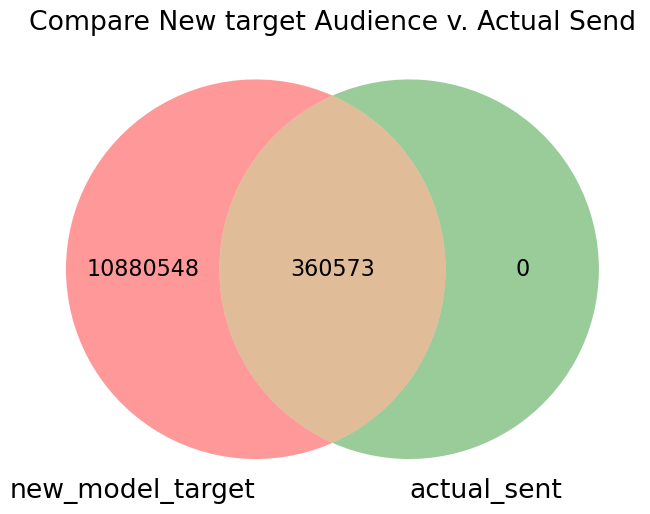

In [19]:
%%time

lbls_ = ['new_model_target', 'actual_sent']
d_compare_audiences = get_venn_sets2(
    df_target_user_ids['user_id'].unique(),
    df_sent_users['user_id'].unique(),
    *lbls_,
)
# d_compare_audiences.keys()

ax = venn2_unweighted(
    [
        set(df_target_user_ids['user_id'].unique()),
        set(df_sent_users['user_id'].unique()),
    ],
    set_labels=['new_model_target', 'actual_sent'],
)
plt.title(f"Compare New target Audience v. Actual Send")

In [20]:
assert 0 == len(d_compare_audiences['actual_sent_only'])

## Get Time-on-Subreddit (ToS) for target user IDs

We'll use these to create weighted embeddings.

**15 SECONDS** ETA for:
- 1 campaign
- 30 day lookback window
- Including actual sent users

---
I'm caching the `selected users` in a table so that it's easier/faster to re-use while testing.

The time-on-subreddit feature is already in gazette features so we don't need to waste time computing them.

Key tables:
- Select users:
    - `data-prod-165221.fact_tables.post_consume_post_detail_view_events` 
- Get ToS:
    - `data-prod-165221.user_feature_platform.time_on_subreddit_pct_time_over_30_day_v1`


In [34]:
%%time
%%bigquery _ --project data-science-prod-218515 

-- Pull the user IDs + time on subreddit
--   Using temp function because it's much faster to expand ToS in BQ than in python
--   But we need to write the data to a table because the response can be huge (billions of rows)
DECLARE PT_TOS DATE DEFAULT "2022-12-01";

CREATE TEMP FUNCTION
tosParser(tosString STRING)
RETURNS STRUCT<
    subreddit_id STRING,
    tos_30_pct FLOAT64
>
LANGUAGE js AS """
   arr = tosString.split(':');
   this.subreddit_id = arr[0].slice(1, -1);
   this.tos_30_pct = parseFloat(arr[1]);
   return this;
"""
;


CREATE OR REPLACE TABLE `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230418`
CLUSTER BY user_id
AS (
WITH tos_filtered AS (
SELECT
    u.user_id
    , t.feature_value
FROM `data-prod-165221.user_feature_platform.time_on_subreddit_pct_time_over_30_day_v1` AS t
    INNER JOIN(
        SELECT
            DISTINCT user_id
        FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230418`
        -- LIMIT 10
    ) AS u
        ON u.user_id = t.entity_id
WHERE DATE(t.pt) = PT_TOS
)
, tos_exploded AS (
SELECT
    user_id
    , tosParser(feature_array_exploded).*
FROM(
    SELECT user_id, feature_array_exploded
    FROM (
        SELECT user_id, SPLIT(RTRIM(LTRIM(feature_value, '{'), '}')) AS feature_array FROM tos_filtered
    ), UNNEST(feature_array) AS feature_array_exploded
)
)


SELECT *
FROM tos_exploded

WHERE
    -- Limit smallest sub b/c at some point it's a waste to try to aggregate such small embeddings
    -- 0.001 -> 1000 subreddits evenly split
    tos_30_pct >= 0.00005
);


Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1797.05query/s] 

CPU times: user 299 ms, sys: 35.6 ms, total: 335 ms
Wall time: 30.4 s


In [40]:
%%time
%%bigquery df_tos_counts --project data-science-prod-218515 
-- Count checks
SELECT
    COUNT(*) AS row_count
    , COUNT(DISTINCT user_id) AS user_id_count
FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230418`
;


Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.05s/rows]

CPU times: user 37.1 ms, sys: 10.6 ms, total: 47.7 ms
Wall time: 1.8 s


In [41]:
df_tos_counts

,row_count,user_id_count
0,753063242,10578950


In [37]:
del df_tos_counts


### Load data from GCS because loading straight from BQ takes too long (stopped after waiting for 30 minutes). 

```bash
# Copy: the -n flag only copies "NEW" files
# !gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m cp -r -n $remote_gs_path $local_f

# rsync can be nicer because with `-n` you get a preview (dry run) before running a command
# !gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n $gcs_tos $local_path_tos
```

Note that it's better to run this command from the CLI because it can crash jupyter (fast log info 

In [42]:
%%time
%%bigquery _ --project data-science-prod-218515 

-- Export data to GCS because querying such a huge table takes forever and a half
EXPORT DATA OPTIONS(
    uri='gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230418/user_tos_30_pct/*.parquet',
    format='PARQUET',
    overwrite=true
) AS
SELECT *
FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230418`
;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 808.00query/s]                          

CPU times: user 72.1 ms, sys: 1.41 ms, total: 73.5 ms
Wall time: 4.66 s


Note:
- The `-r` flag creates a "dry-run" (only tells you what will happen)
- for final CLI command remove this flat (`-r`)

Example output:
```bash
$ gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230417/user_tos_30_pct/ /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/de_only_20230417/user_tos_30_pct

...
Copying gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230417/user_tos_30_pct/000000000172.parquet...
 \ [209/209 files][635.8 MiB/635.8 MiB] 100% Done                                 
 Operation completed over 209 objects/635.8 MiB. 

...

Copying gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230418/user_tos_30_pct/000000001369.parquet...
 | [1.4k/1.4k files][  5.2 GiB/  5.2 GiB] 100% Done     0.0 B/s                  
 Operation completed over 1.4k objects/5.2 GiB. 
```

In [44]:
bucket_name_ = 'i18n-subreddit-clustering'
gcs_tos = f"gs://{bucket_name_}/pn_model/runs/de_only_20230418/user_tos_30_pct/"

path_local_cache = Path(f"/home/jupyter/subreddit_clustering_i18n/data/local_cache/{bucket_name_}/")
local_path_tos = (
    path_local_cache / 
    gcs_tos.split(f"{bucket_name_}/")[1]
)
Path.mkdir(local_path_tos, exist_ok=True, parents=True)


print(f"GCS URI:\n  {gcs_tos}\nLocal path:\n  {local_path_tos}")

print(f"\nCLI command DRY RUN:")
!echo gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n $gcs_tos $local_path_tos
        
print(f"\nCLI command ACTUAL run")
!echo gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r $gcs_tos $local_path_tos

GCS URI:
  gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230418/user_tos_30_pct/
Local path:
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/de_only_20230418/user_tos_30_pct

CLI command DRY RUN:
gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230418/user_tos_30_pct/ /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/de_only_20230418/user_tos_30_pct

CLI command ACTUAL run
gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230418/user_tos_30_pct/ /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/de_only_20230418/user_tos_30_pct


In [46]:
# Delete: If we need to delete data that was incorrect
# !rm -r $local_path_tos

In [48]:
# !gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r $gcs_tos $local_path_tos

In [49]:
%%time

df_user_tos = pl.read_parquet(f"{local_path_tos}/*.parquet")

CPU times: user 1min 50s, sys: 28.5 s, total: 2min 19s
Wall time: 11 s


In [50]:
df_user_tos.shape

(753063242, 3)

In [51]:
%%time
df_user_tos.sample(n=int(1e6)).describe()

CPU times: user 6.77 s, sys: 58.1 ms, total: 6.83 s
Wall time: 5.75 s


describe,user_id,subreddit_id,tos_30_pct
str,str,str,f64
"""count""","""1000000""","""1000000""",1e6
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,0.013974
"""std""",null,null,0.067934
"""min""","""t2_1000ih""","""t5_1009a3""",0.00005
"""max""","""t2_zzzye""","""t5_zzszh""",1.0
"""median""",null,null,0.00078


In [52]:
df_user_tos.head()

user_id,subreddit_id,tos_30_pct
str,str,f64
"""t2_100bpa""","""t5_leqac""",0.00008
"""t2_100bpa""","""t5_2qlr2""",0.00098
"""t2_101729""","""t5_3n7fs""",0.00006
"""t2_101729""","""t5_2w7mz""",0.00453
"""t2_1021ns""","""t5_2szd9""",0.00018


# Other Transforms 

We don't need these transforms for ANN, but will use it for modeling step
- Count of subreddits per user for ToS

Other data:
- Subscribed to target subreddit
- Age of account
- Activity in L14 days
- etc...



---


# Compute user-level weighted embedding

now that we have the long df, let's compute the user-level weighted embedding (multiply weights x embedding & groupby user-id)

## Run on all users

Batches of 150-million user<>subreddit weighted embeddings was too much memory (over 1.2 TB). So the kernel gets killed/dies.

Instead, try to run in batches of
- 80 to 100 million ToS rows

---

Example ETAs:

```bash
# 800k users | 130 million ToS rows
07:08:08 | INFO | "Append subreddit embeddings to user ToS"
07:08:13 | INFO | "Compute weighted avg embedding for user-level"
07:09:49 | INFO | "Compute AGGREGATED user-level embedding..."
(130601209, 100)
(856211, 101)
CPU times: user 18min 9s, sys: 8min 21s, total: 26min 31s
Wall time: 4min 52s


# 9.8 million users |  764.5 million ToS rows
10:49:14 | INFO | "Compute weighted ToS embeddings..."
10:58:43 | INFO | "(764565252, 102) <- df.shape ToS with weighted embedddings"
10:58:43 | INFO | "Delete temp df to free up memory"
10:58:43 | INFO | "Compute AGGREGATED user-level embedding..."
10:59:50 | INFO | "(9874962, 101) <- df.shape User weighted embedddings"
(764565252, 102)
(9874962, 101)
CPU times: user 2h 53min 2s, sys: 44min 23s, total: 3h 37min 25s
Wall time: 23min 30s


# 3.1 million users | 96.5 million ToS rows
18:34:23 | INFO | "Compute weighted ToS embeddings..."
18:34:53 | INFO | "(96519368, 102) <- df.shape ToS with weighted embedddings"
18:34:53 | INFO | "Delete temp df to free up memory"
18:34:54 | INFO | "Compute AGGREGATED user-level embedding..."
18:35:03 | INFO | "(3164772, 101) <- df.shape User weighted embedddings"
(3164772, 101)
CPU times: user 21min 57s, sys: 5min 1s, total: 26min 59s
Wall time: 2min 3s
```

23:10:17 | INFO | "753,063,242 <- Data Size"
23:10:17 | INFO | "80,000,000 <- Batch Size"
23:10:17 | INFO | "0,000,010 <- Chunks"
23:10:17 | INFO | "Append subreddit embeddings to user ToS"
23:11:28 | INFO | "(677271810, 103) <- df.shape ToS with raw embeddings (no nulls)"
23:11:29 | INFO | "Create DAG for weighted avg embedding per user+subreddit"


  0%|          | 0/10 [00:00<?, ?it/s]

23:21:15 | INFO | "Dask visualize DAG"


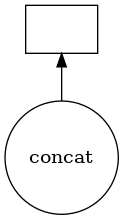

23:21:20 | INFO | "Compute weighted ToS embeddings..."
23:28:57 | INFO | "(677271810, 102) <- df.shape ToS with weighted embedddings"
23:28:57 | INFO | "Delete temp df to free up memory"
23:28:58 | INFO | "Compute AGGREGATED user-level embedding..."
23:29:50 | INFO | "(10533999, 101) <- df.shape User weighted embedddings"


(10533999, 101)
CPU times: user 2h 21min 7s, sys: 41min 1s, total: 3h 2min 8s
Wall time: 19min 47s


In [53]:
%%time

# when computing on full data set, we need to batch b/c the computer will run out of RAM if/when converting parquet to numpy
n_sample = None  # None  # None  int(10e6)

if n_sample is None:
    df_user_tos_proc_ = df_user_tos
else:
    df_user_tos_proc_ = df_user_tos.sample(n=n_sample, seed=42)
n_size = len(df_user_tos_proc_)

batch_size = int(80e6)  # int(110e6), 9e6 = 9Million
n_chunks = 1 + n_size // batch_size
iter_chunks = range(n_chunks)

info(f"{n_size:09,.0f} <- Data Size")
info(f"{batch_size:09,.0f} <- Batch Size")
info(f"{n_chunks:09,.0f} <- Chunks")


info(f"Append subreddit embeddings to user ToS")
df_user_emb_tmp = (
    df_user_tos_proc_
    .join(
        df_sub_emb.drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
    # Drop or replace nulls as early as possible
    .drop_nulls()
)
info(f"{df_user_emb_tmp.shape} <- df.shape ToS with raw embeddings (no nulls)")
gc.collect()

info(f"Create DAG for weighted avg embedding per user+subreddit")
# Use dask.delayed() to compute these in parallel & prevent some OOM errors
l_dfs_tos_wt = list()
for i in tqdm(iter_chunks, mininterval=0.1, ascii=True):
    l_dfs_tos_wt.append(
        df_user_emb_tmp[['user_id', 'subreddit_id']][:batch_size]
        .with_columns(
            pl.DataFrame(
                data=(
                    np.multiply(
                        df_user_emb_tmp['tos_30_pct'][:batch_size].to_numpy(),
                        df_user_emb_tmp[l_emb_cols][:batch_size].to_numpy().T
                    ).T
                ),
                schema=l_emb_cols,
            )
        )
    )
    # delete processed rows to save space
    df_user_emb_tmp = df_user_emb_tmp[batch_size:]
    gc.collect()

df_user_emb_tmp_wt_del = dask.delayed(pl.concat)(
    l_dfs_tos_wt, how='vertical', parallel=True
)
info(f"Dask visualize DAG")
display(df_user_emb_tmp_wt_del.visualize(
    f"dask_DAG-{n_size}_data-{batch_size}_batch_size-{n_chunks}_chunks.png"
))
gc.collect()
info(f"Compute weighted ToS embeddings...")
df_user_emb_tmp_wt = df_user_emb_tmp_wt_del.compute()
info(f"{df_user_emb_tmp_wt.shape} <- df.shape ToS with weighted embedddings")

info(f"Delete temp df to free up memory")
del df_user_emb_tmp, l_dfs_tos_wt
gc.collect()

info(f"Compute AGGREGATED user-level embedding...")
df_user_emb = (
    df_user_emb_tmp_wt
    .groupby(
        ['user_id']
    )
    .agg(
        [
            pl.col(l_emb_cols).mean()
        ]
    )
)
info(f"{df_user_emb.shape} <- df.shape User weighted embedddings")
del df_user_emb_tmp_wt
gc.collect()
print(df_user_emb.shape)

In [54]:
df_user_emb[:4, :15]

user_id,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012,embedding_013
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""t2_13ijthd7""",-0.000477,0.001542,0.001145,-0.001058,-0.000474,0.001527,0.000915,-0.000072,0.004102,0.00073,-0.000558,0.002428,0.001093,-0.000813
"""t2_twnmqqq5""",-0.260322,0.109462,0.022264,-0.029227,0.011456,0.055284,0.026742,-0.035801,0.196079,0.02531,-0.083155,-0.028771,0.057644,0.038707
"""t2_mo9rte98""",0.007198,-0.067097,0.049512,-0.168822,-0.214957,0.266824,0.233859,-0.152512,0.133501,-0.065121,-0.171795,0.427113,0.032122,0.057951
"""t2_u3470wrj""",-0.034847,0.114699,-0.055321,-0.057482,-0.008865,0.004448,-0.013766,0.028061,0.067108,0.133352,0.058031,0.080663,0.061942,-0.061296


### Save user embeddings

In [55]:
%%time

r_, c_ = df_user_emb.shape

f_user_embedding_name = (
    path_this_model / 
    f"df_user_embedding-{datetime.utcnow().strftime('%Y-%m-%d_%H%M')}"
    f"-{r_}_by_{c_}.parquet"
)
info(f"User embedding name:\n{f_user_embedding_name}")

df_user_emb.write_parquet(
    f_user_embedding_name
)

del r_, c_

23:30:05 | INFO | "User embedding name:
/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-18_224701/df_user_embedding-2023-04-18_2330-10533999_by_101.parquet"


CPU times: user 1min 29s, sys: 10.8 s, total: 1min 39s
Wall time: 1min 41s


In [56]:
l_target_subreddits

['de']

# Calculate ANN index & ANN users


ETA for 1 campaign (~3 million users):
- Compute index: 4 minutes
- Compute ANN: 

```bash
# index creation, 3.2 million users
CPU times: user 3h 23min 8s, sys: 2min 31s, total: 3h 25min 40s
Wall time: 3min 22s

# ANN
22:26:11 | INFO | "Start computing ANNs for n=3,164,772"
22:27:18 | INFO | "(3164772, 4) <- df_nns_by_vector shape"
22:27:18 | INFO | "Adding index labels (subreddit ID & Name)"
22:27:20 | INFO | "Done adding index names"
22:27:20 | INFO | "(3164772, 5) <- df_nns_by_v shape"
22:27:20 | INFO | "Calculating cosine similarity..."
CPU times: user 1min 5s, sys: 2.9 s, total: 1min 8s
Wall time: 1min 8s
```

```bash
# Index
23:31:49 | INFO | "10,533,999 <- Items for ANNOY index"
23:31:59 | INFO | "Start creating ANNOY index..."
CPU times: user 12h 27s, sys: 6min 30s, total: 12h 6min 58s
Wall time: 11min 53s

# ANN
23:43:43 | INFO | "Start computing ANNs for n=10,533,999"
23:47:47 | INFO | "(10533999, 4) <- df_nns_by_vector shape"
23:47:47 | INFO | "Adding index labels (subreddit ID & Name)"
23:47:53 | INFO | "Done adding index names"
23:47:53 | INFO | "(10533999, 5) <- df_nns_by_v shape"
23:47:53 | INFO | "Calculating cosine similarity..."
CPU times: user 3min 59s, sys: 11 s, total: 4min 10s
Wall time: 4min 10s

```
---

In PROD: 
- create one index PER Subreddit<>COUNTRY
    - This way we ensure a minimum of N users per country
    
In this test, we've already filtered to only one country, so no need to create individual index.


In [57]:
df_user_emb.shape

(10533999, 101)

In [58]:
# df_user_emb.head()

In [59]:
d_ann_params = {
    'n_trees': 200,
    'metric': 'angular',
}

In [60]:
%%time

index_cols = ['user_id']
l_embedding_cols = [c for c in df_user_emb.columns if c.startswith('embedding_')]


# This version of AnnoyIndex expects a pandas DF
#  so it might take a little extra time to compute
info(f"{len(df_user_emb):,.0f} <- Items for ANNOY index")
nn_index = AnnoyIndex(
    df_user_emb[l_embedding_cols + index_cols].to_pandas(),
    index_cols=index_cols,
    metric=d_ann_params['metric'],
    n_trees=d_ann_params['n_trees'],
)

info(f"Start creating ANNOY index...")
nn_index.build()

23:31:49 | INFO | "10,533,999 <- Items for ANNOY index"
23:31:59 | INFO | "Start creating ANNOY index..."


CPU times: user 12h 27s, sys: 6min 30s, total: 12h 6min 58s
Wall time: 11min 53s


In [61]:
# convert target sub into a vector for query
q_target_sub = (
    df_sub_emb
    .filter(
        df_sub_emb['subreddit_name'] == l_target_subreddits[0]
    )
    .select(
        pl.col(l_emb_cols)
    )
    .to_numpy()
    [0]
)

q_target_sub.shape

(100,)

In [62]:
%%time
# inputs
vector: Union[np.array, pd.Series] = q_target_sub
n: int = len(df_user_emb)
search_k = -1
include_distances: bool = True

col_distance: str = 'distance'
col_distance_rank: str = 'distance_rank'
col_vector_name: str = 'subreddit_name'
col_cosine_similarity: str = 'cosine_similarity'

append_i = True
cosine_similarity = True


# Execute fxn:
info(f"Start computing ANNs for n={n:,.0f}")
i_nn: Tuple[int, float] = nn_index.index.get_nns_by_vector(
    vector=vector,
    n=n, 
    search_k=search_k, 
    include_distances=include_distances,
)


# TBD: skip the first item because the most similar one is always self?
df_nns_by_v = pd.DataFrame(
    {
        'subreddit_name': [l_target_subreddits[0]] * n,
        'nn_ix': i_nn[0][:],
        col_distance: i_nn[1][:],
        col_distance_rank: [v for v in range(1, n + 1)]
    },
)
info(f"{df_nns_by_v.shape} <- df_nns_by_vector shape")

if append_i:
    info(f"Adding index labels (subreddit ID & Name)")
    df_labels_reset_index = nn_index.index_labels_df.copy().reset_index(drop=True)

    # Append index (e.g., IDs & names) for ANNs (nearest neighbors)
    # NOTE: using .merge() based on index_labels_df is 100x (or more) faster than
    #   pd.Series().replace() with a dictionary(!!)
    df_nns_by_v = (
        df_labels_reset_index
        # We only append the ANN index because the annoy index doesn't have info about 
        # the vector (subreddit) we searched
        #  We shouldn't need to reset or rename the index
        .merge(
            df_nns_by_v,
            how='right',
            left_index=True,
            right_on='nn_ix',
        )
    )
    info(f"Done adding index names")
    info(f"{df_nns_by_v.shape} <- df_nns_by_v shape")

if cosine_similarity:
    # from: https://github.com/spotify/annoy/issues/112#issuecomment-686513356
    # ```
    # cosine_similarity = 1 - cosine_distance^2/2
    # ```
    if nn_index.metric == 'angular':
        info(f"Calculating cosine similarity...")
        df_nns_by_v[col_cosine_similarity] = (
            1 -
            (df_nns_by_v['distance'] ** 2) / 2
        )
    else:
        logging.error(
            f"Cannont calculate cosine similarity because metric is not `angular`"
            f"\nInput metric: {nn_index.metric}"
        )

23:43:43 | INFO | "Start computing ANNs for n=10,533,999"
23:47:47 | INFO | "(10533999, 4) <- df_nns_by_vector shape"
23:47:47 | INFO | "Adding index labels (subreddit ID & Name)"
23:47:53 | INFO | "Done adding index names"
23:47:53 | INFO | "(10533999, 5) <- df_nns_by_v shape"
23:47:53 | INFO | "Calculating cosine similarity..."


CPU times: user 3min 59s, sys: 11 s, total: 4min 10s
Wall time: 4min 10s


In [63]:
df_nns_by_v.head(9)

,user_id,subreddit_name,nn_ix,distance,distance_rank,cosine_similarity
0,t2_uie1132w,de,3102007,0.0,1,1.0
1,t2_uae9cvc1,de,2672992,0.0,2,1.0
2,t2_8to6xu36,de,8938782,0.0,3,1.0
3,t2_8jyuowfl,de,3847963,0.0,4,1.0
4,t2_ughg2trb,de,4343693,0.0,5,1.0
5,t2_u92yu1it,de,3569721,0.0,6,1.0
6,t2_tpg457id,de,6514272,0.0,7,1.0
7,t2_ucezlpjz,de,1653188,0.0,8,1.0
8,t2_9ij0gxtf,de,2181456,0.0,9,1.0


In [64]:
df_nns_by_v.tail(20)

,user_id,subreddit_name,nn_ix,distance,distance_rank,cosine_similarity
10533979,t2_uewj12d5,de,8335532,1.444018,10533980,-0.042595
10533980,t2_e78zinyf,de,8392788,1.444032,10533981,-0.042614
10533981,t2_ue35qe7p,de,9839029,1.444422,10533982,-0.043178
10533982,t2_i83dhc60,de,3455160,1.444773,10533983,-0.043685
10533983,t2_5afsskth,de,4211846,1.445634,10533984,-0.044928
10533984,t2_97zrwzqn,de,361316,1.446601,10533985,-0.046327
10533985,t2_um2t1x2z,de,508514,1.446601,10533986,-0.046327
10533986,t2_u6cbq115,de,5266519,1.446601,10533987,-0.046327
10533987,t2_uf67ypna,de,7743480,1.446601,10533988,-0.046327
10533988,t2_un0lq8jh,de,1128082,1.447782,10533989,-0.048036


In [65]:
%%time

r_, c_ = df_nns_by_v.shape 
info(f"{r_:,.0f}, {c_:,.0f} <- df_distance shape")

info(f"Save df-ANN to parquet...")
df_nns_by_v.to_parquet(
    path_this_model / f"df_ann_distance_to_target-{r_}_{c_}.parquet",
    index=False,
)
del r_, c_

23:47:53 | INFO | "10,533,999, 6 <- df_distance shape"
23:47:53 | INFO | "Save df-ANN to parquet..."


CPU times: user 4.28 s, sys: 285 ms, total: 4.57 s
Wall time: 4.5 s


# Combine distance and other features into table for model training
This should be the training data for modeling. DO it in a separate notebook

Include query from dashboard:
- sent flag
- received flag
- clicked flag

New info:
- subscribe
- 
